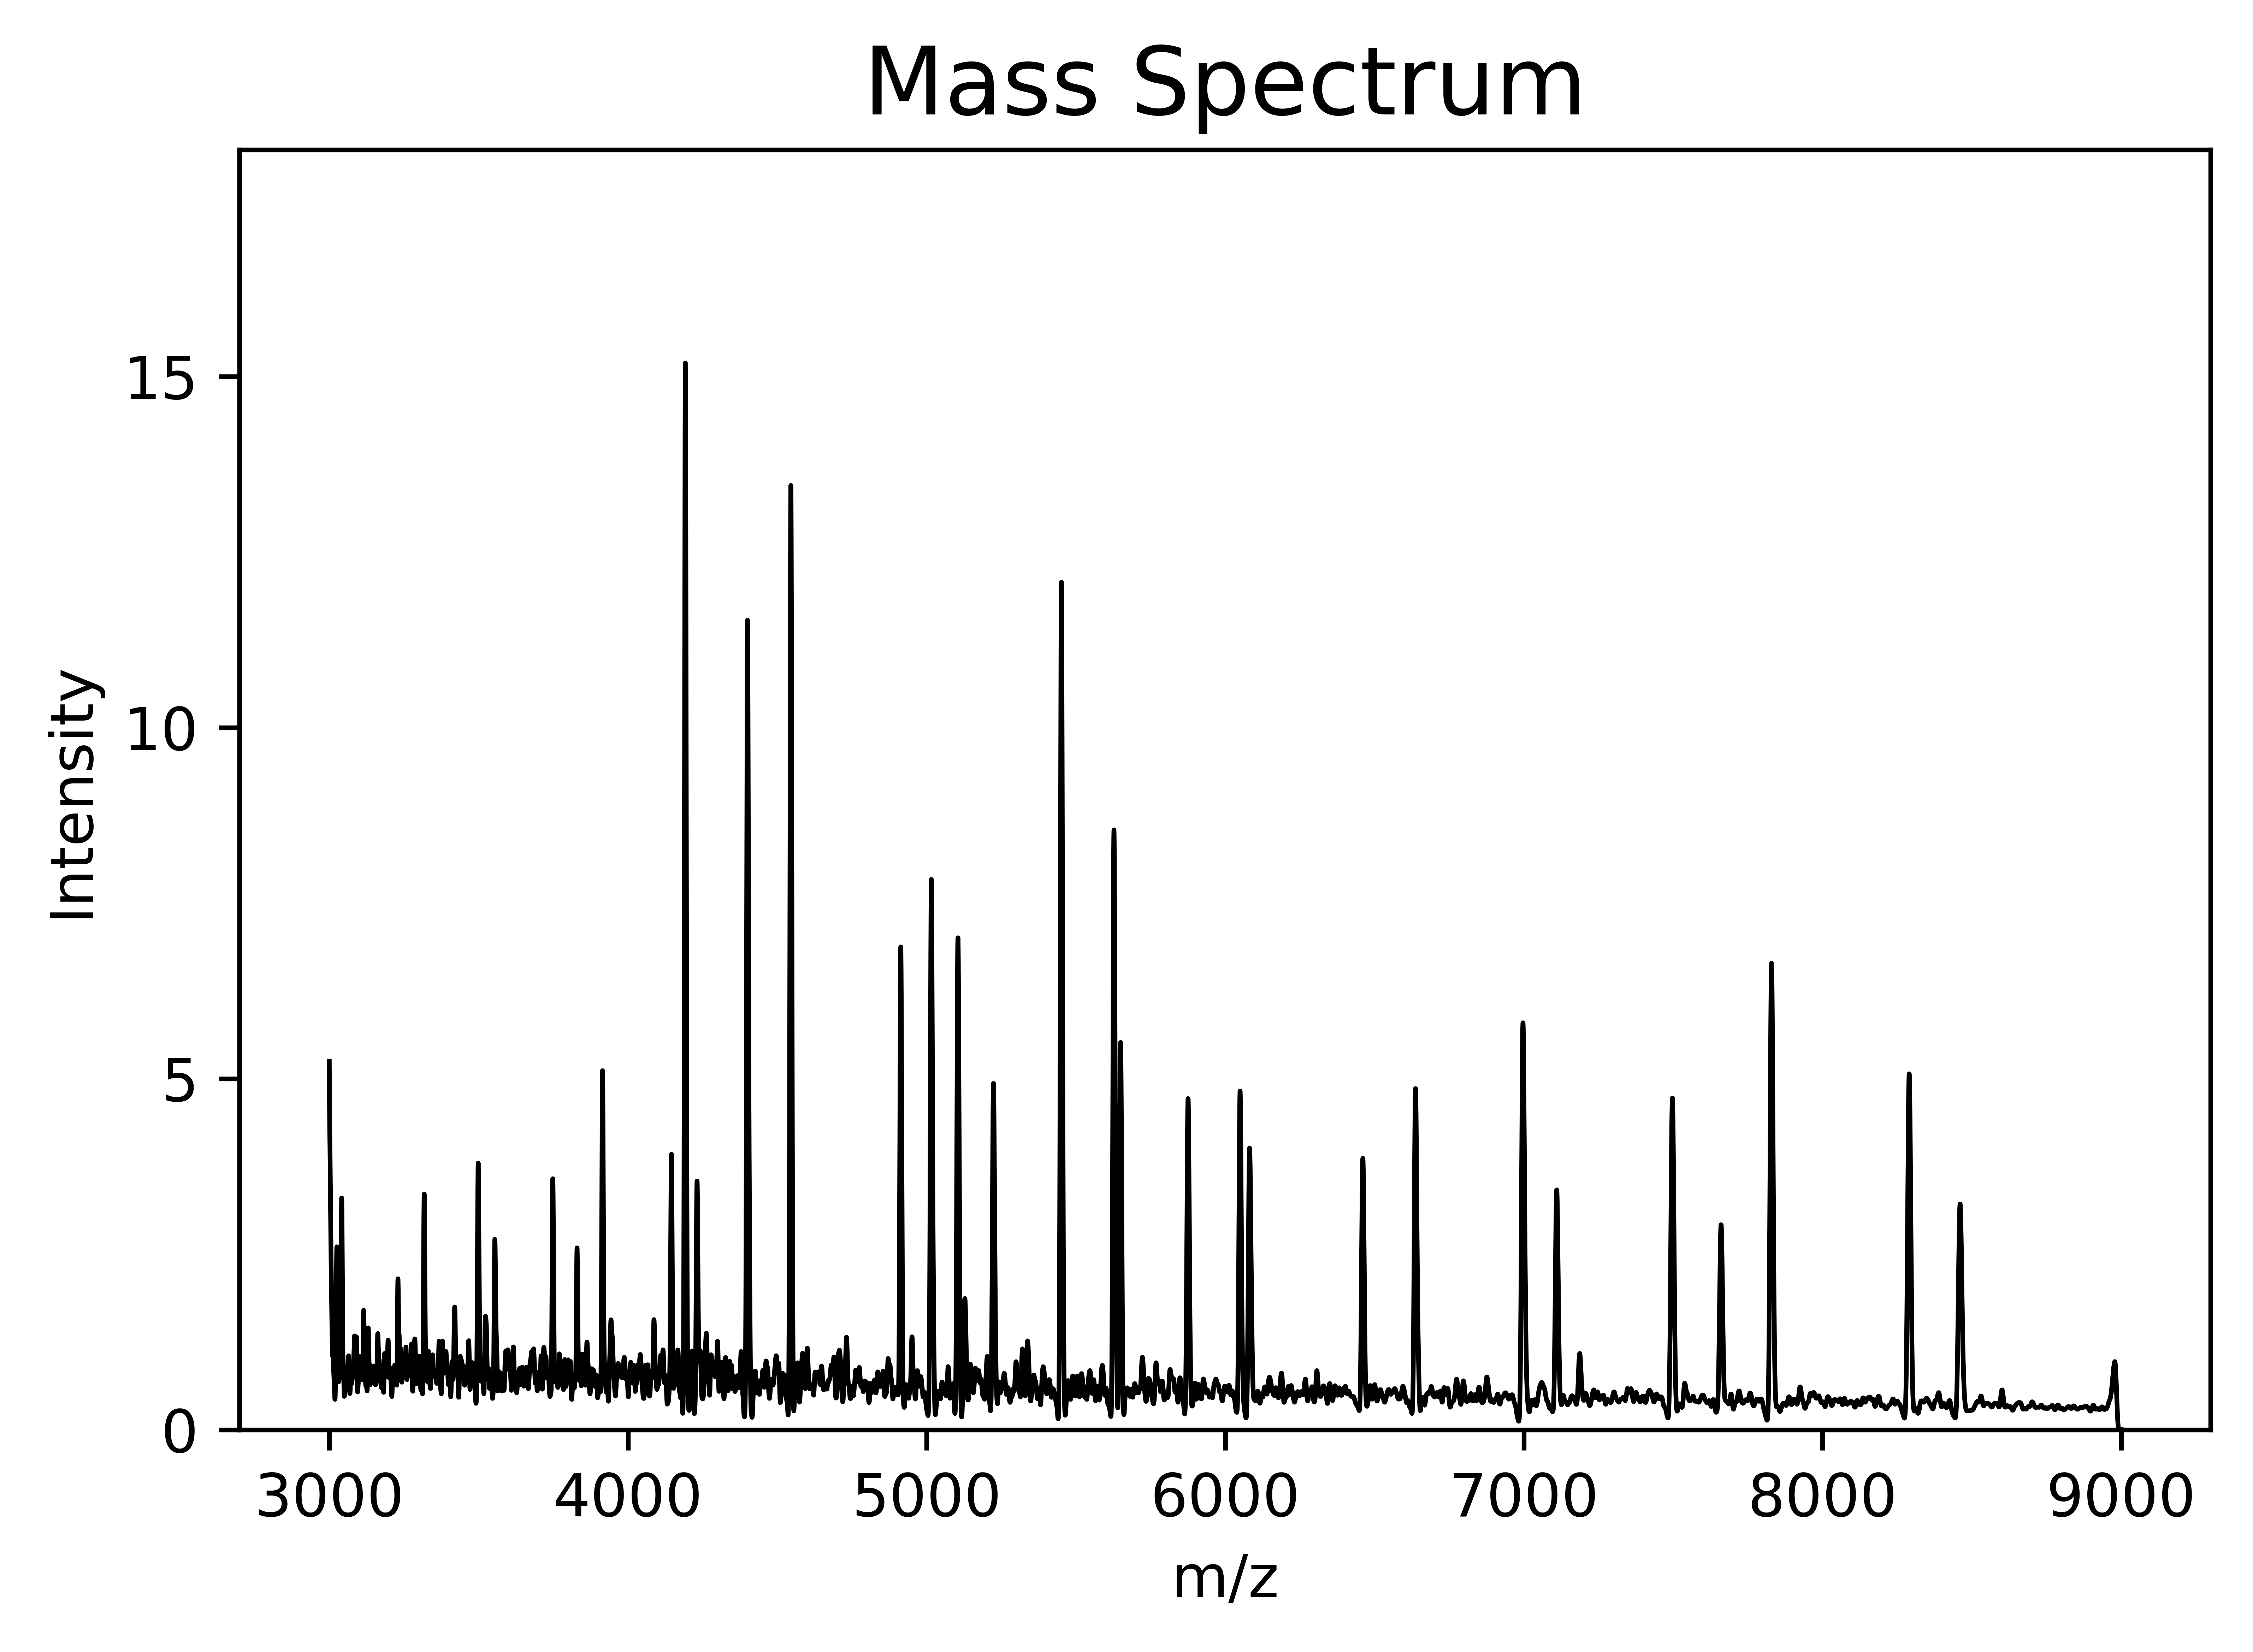

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_csv(
    r'E:\研究生\核酸质谱数据\核酸质谱数据\01 EL\ascii\20160928009_0001-2E5.txt',
    sep=',', header=None, names=['m/z', 'Intensity']
)

# 2. 绘图
plt.figure(figsize=(6, 4),dpi=1200)
plt.plot(df['m/z'], df['Intensity'], color='black', linewidth=0.8)
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})
# 3. 坐标轴范围

plt.ylim(0, df['Intensity'].max()* 1.2 )


# 6. 其他细节
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spectrum')

plt.show()

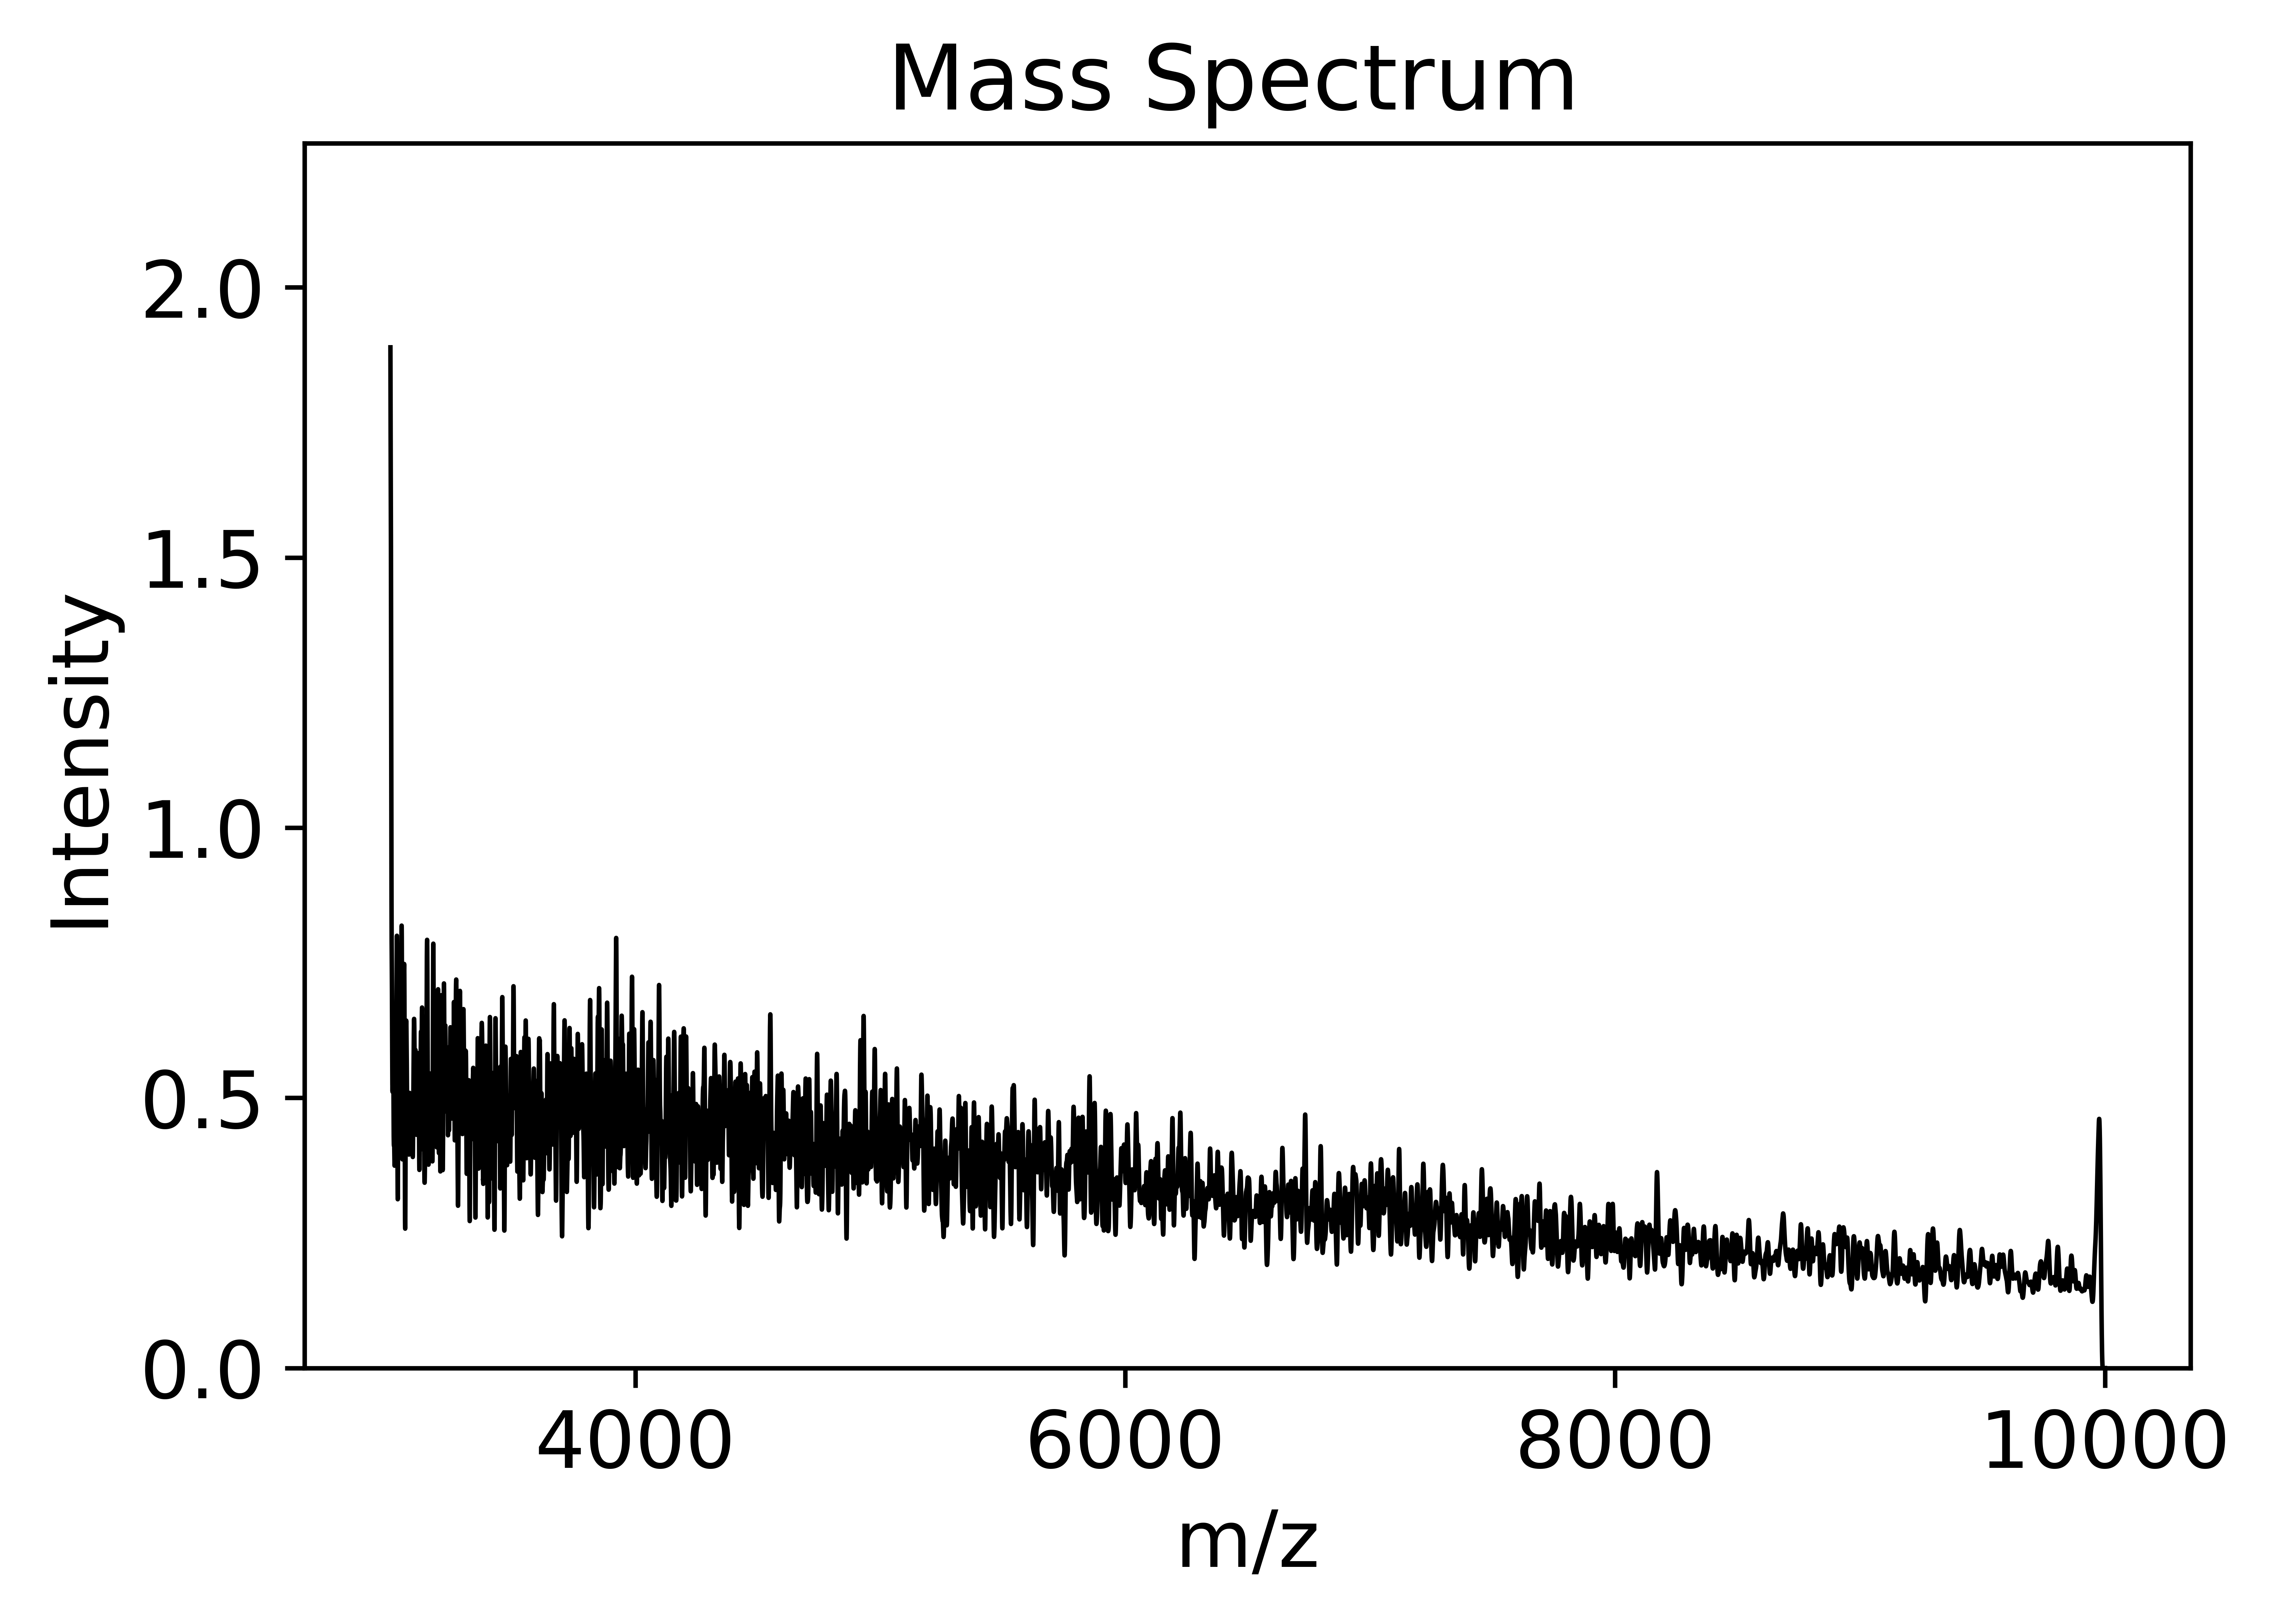

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_csv(
    r'E:\研究生\核酸质谱数据\核酸质谱数据\02 空白\TXT\1E1_.txt',
    sep=',', header=None, names=['m/z', 'Intensity']
)

# 2. 绘图
plt.figure(figsize=(6, 4),dpi=1200)
plt.plot(df['m/z'], df['Intensity'], color='black', linewidth=0.8)

# 3. 坐标轴范围
plt.ylim(0, df['Intensity'].max()* 1.2  )


# 6. 其他细节
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spectrum ')

plt.show()

(0.0, 18.2322)

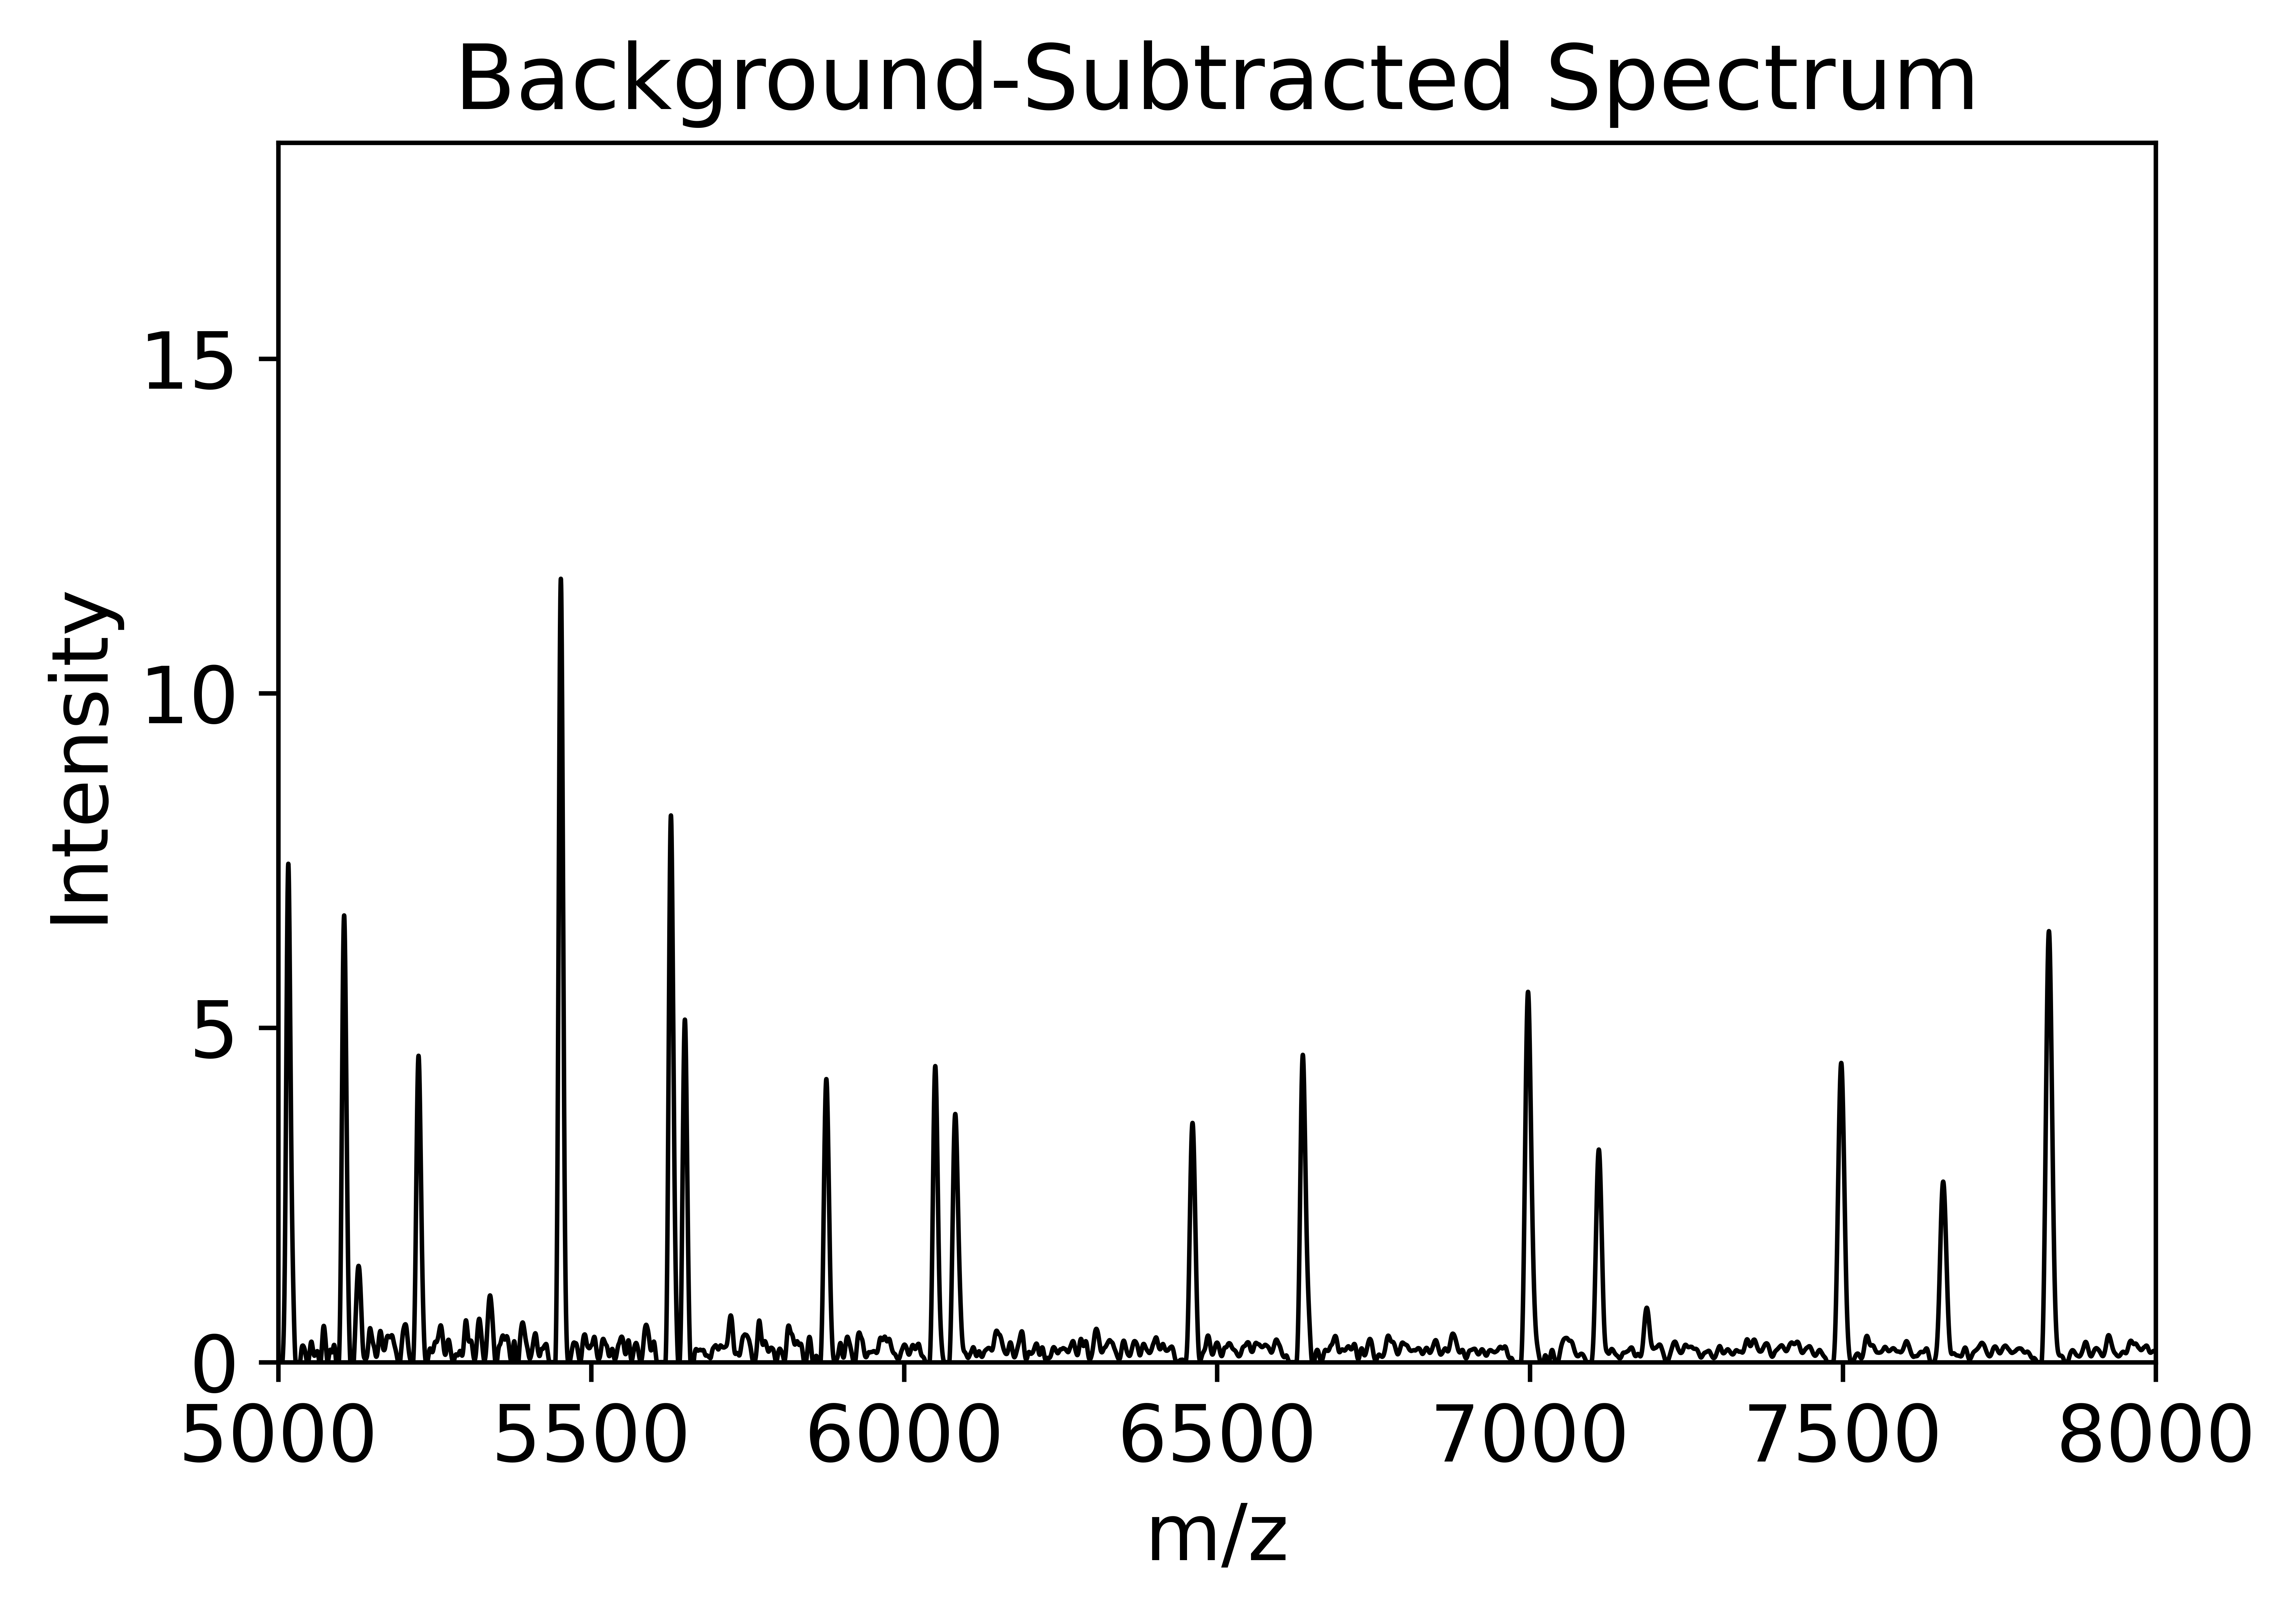

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# --- 1. 读取样品和空白数据 ---

# 读取样品数据
df_sample = pd.read_csv(
    r'E:\研究生\核酸质谱数据\核酸质谱数据\01 EL\ascii\20160928009_0001-2E5.txt',
    sep=',', header=None, names=['m/z', 'Intensity']
)
mz_sample, int_sample = df_sample['m/z'].values, df_sample['Intensity'].values

# 读取空白数据
df_blank = pd.read_csv(
    r'E:\研究生\核酸质谱数据\核酸质谱数据\02 空白\TXT\1E1_.txt',
    sep=',', header=None, names=['m/z', 'Intensity']
)
mz_blank, int_blank = df_blank['m/z'].values, df_blank['Intensity'].values

# --- 2. 数据对齐与相减 ---

# 创建一个插值函数，用于将空白谱图的数据插值到样品谱图的m/z轴上
# kind='linear' 表示使用线性插值
f_blank = interp1d(mz_blank, int_blank, kind='linear', bounds_error=False, fill_value=0.0)

# 在样品的m/z点上，计算插值后的空白强度
int_blank_interp = f_blank(mz_sample)

# 样品强度减去插值后的空白强度
int_subtracted = int_sample - int_blank_interp

# 将负值强度设置为0（因为强度不能为负）
int_subtracted[int_subtracted < 0] = 0.0

# --- 3. 绘图展示 ---
plt.figure(figsize=(6, 4), dpi=1200)
y_max = int_sample.max() * 1.2
plt.plot(mz_sample, int_subtracted, color='black', linewidth=0.8)
plt.title('Background-Subtracted Spectrum')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.xlim(5000,8000)
plt.ylim(0, y_max)

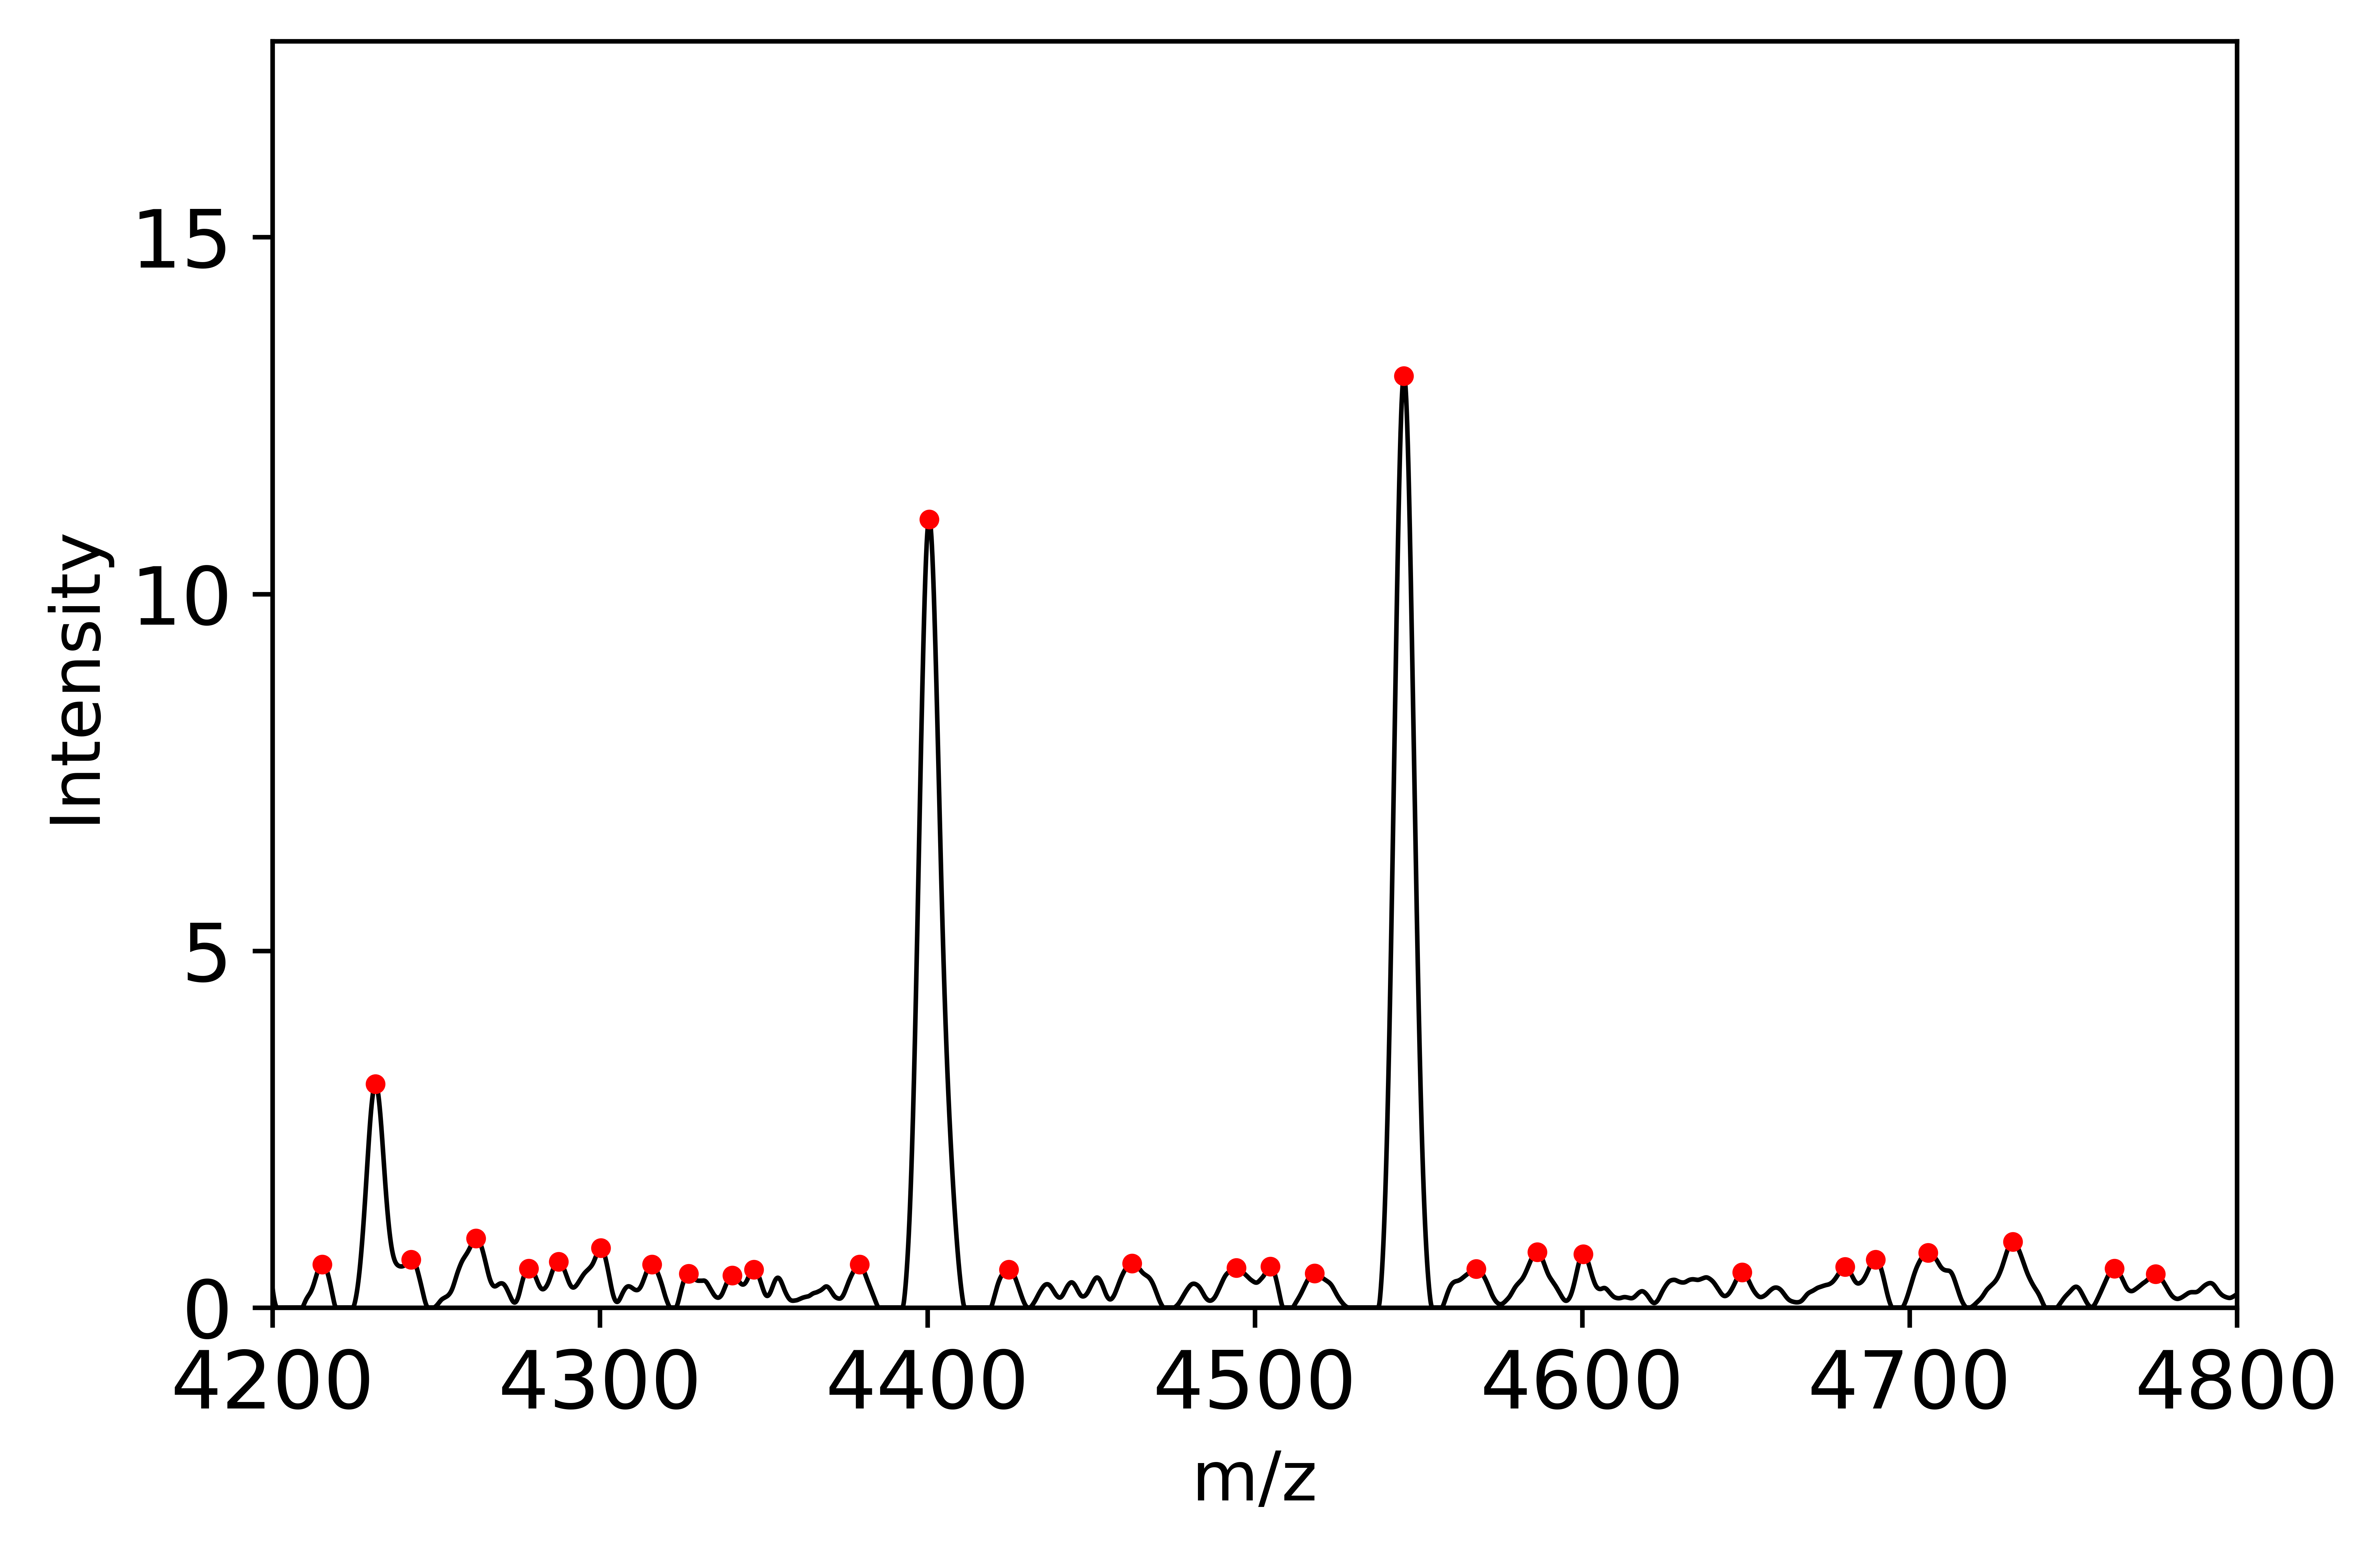

--- 寻峰结果统计 ---
检测到的峰总数 (S/N > 3): 88
检测到的峰位置 (m/z): [3915.   3942.57 3968.53 3989.86 4006.41 4020.73 4034.3  4041.53 4066.58
 4087.21 4110.19 4117.39 4145.66 4167.27 4192.22 4215.21 4231.44 4242.35
 4262.15 4278.28 4287.39 4300.23 4315.84 4327.05 4340.44 4347.05 4379.26
 4400.58 4424.92 4462.52 4494.36 4504.79 4518.26 4545.55 4567.67 4586.29
 4600.38 4648.91 4680.28 4689.6  4705.69 4731.59 4762.62 4775.12 4871.33
 4876.24 4913.6  4951.11 5015.85 5072.59 5105.14 5128.15 5146.6  5163.03
 5202.99 5224.05 5259.37 5299.8  5320.95 5338.21 5390.37 5410.6  5451.39
 5587.77 5627.32 5649.57 5722.9  5768.37 5815.4  5875.68 5927.98 6049.66
 6081.59 6147.69 6188.   6307.08 6460.81 6636.98 6876.67 6996.93 7110.02
 7186.55 7497.31 7660.26 7829.2  8290.05 8460.67 8978.72]
匹配到的目标位点数量: 22/22


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. 数据预处理 (与之前代码相同) ---

# 读取样品和空白数据
df_sample = pd.read_csv(
    r'E:\研究生\核酸质谱数据\核酸质谱数据\01 EL\ascii\20160928009_0001-2E5.txt',
    sep=',', header=None, names=['m/z', 'Intensity'])
m_sample, i_sample = df_sample['m/z'].values, df_sample['Intensity'].values

df_blank = pd.read_csv(
    r'E:\研究生\核酸质谱数据\核酸质谱数据\02 空白\TXT\1E1_.txt',
    sep=',', header=None, names=['m/z', 'Intensity'])
m_blank, i_blank = df_blank['m/z'].values, df_blank['Intensity'].values

# 截取、背景扣除和平滑
xmin, xmax = 3900, 9000
mask_sample = (m_sample >= xmin) & (m_sample <= xmax)
m_crop = m_sample[mask_sample]
i_sample_crop = i_sample[mask_sample]

f_blank = interp1d(m_blank, i_blank, kind='linear', bounds_error=False, fill_value=0.0)
i_blank_interp = f_blank(m_crop)
i_subtracted = i_sample_crop - i_blank_interp
i_subtracted[i_subtracted < 0] = 0.0

sigma = 2
i_smoothed = gaussian_filter(i_subtracted, sigma=sigma)

# --- 2. 寻峰 (与之前代码相同) ---
peaks_idx, _ = find_peaks(i_smoothed, distance=5)
noise = np.median(np.abs(i_subtracted - np.median(i_subtracted))) / 0.6745
sn = i_smoothed[peaks_idx] / noise
peaks_mz = m_crop[peaks_idx][sn > 3]
peaks_intensity = i_smoothed[peaks_idx][sn > 3]

# 位点-产物表
sites = [
    ('281C>T',  'T',  4175.8,  'C',   4191.8),
    ('2027T>A', 'T',  4399.9,  'A',   4455.8),
    ('299_300delAT', 'AT', 4545, 'DEL', 4561),
    ('235delC', 'DEL', 4873.2, 'C',   4913.2),
    ('1226G>A', 'A',  4999.3,  'G',   5015.3),
    ('538C>T',  'C',  5104.4,  'T',   5184.3),
    ('IVS7-2A>G', 'G', 5143.4, 'A',   5223.3),
    ('1229C>T', 'T',  5434.6,  'C',   5450.6),
    ('109G>A',  'G',  5626.7,  'A',   5706.6),
    ('35delG',  'G',  5648.7,  'DEL', 5672.7),
    ('176_191del16', 'GCTGCAAGAACGTGTG', 5874.9, 'DEL', 5930.8),
    ('1555A>G', 'G',  6000.9,  'A',   6080.9),
    ('2162C>T', 'C',  6049,    'T',   6128.9),
    ('1975G>C', 'C',  6596.3,  'G',   6636.4),
    ('1095T>C', 'C',  6916.6,  'T',   6996.5),
    ('2168A>G', 'G',  7029.6,  'A',   7109.5),
    ('1494C>T', 'C',  7829.2,  'T',   7909.1),
    ('1174A>T', 'T',  7440.9,  'A',   7496.8),
    ('547G>A',  'G',  7660,    'A',   7739.9),
    ('IVS15+5G>A', 'G', 8290.5, 'A',   8370.4),
    ('589G>A',  'G',  8461.5,  'A',   8541.5),
    ('ACTB',    'C',  6420.2,  'G',   6460.2),
]

# --- 3. 单独绘制寻峰结果图 ---
plt.figure(figsize=(6, 4), dpi=1200)
color1, color2 = 'tab:blue', 'tab:orange'

# 绘制平滑后的谱图作为背景
plt.plot(m_crop, i_smoothed, color='black', lw=0.8, label=f'Gaussian Smoothed Spectrum (σ={sigma})')

# 用红色圆点突出显示所有检测到的峰
plt.scatter(peaks_mz, peaks_intensity, color='red', s=6, zorder=4, label=f'Detected Peaks (S/N > 3, n={len(peaks_mz)})')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})



plt.xlabel('m/z', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.xlim(4200, 4800)
# 调整y轴上限，留出足够空间显示标注
plt.ylim(0, i_smoothed.max() * 1.2)


plt.tight_layout()
plt.show()

# --- 4. 输出寻峰结果统计 ---
print("--- 寻峰结果统计 ---")
print(f"检测到的峰总数 (S/N > 3): {len(peaks_mz)}")
print(f"检测到的峰位置 (m/z): {peaks_mz.round(2)}")

matched_sites_count = 0
for site, _, mz1, _, mz2 in sites:
    if any(np.abs(peaks_mz - mz1) < 3) or any(np.abs(peaks_mz - mz2) < 3):
        matched_sites_count += 1

print(f"匹配到的目标位点数量: {matched_sites_count}/{len(sites)}")

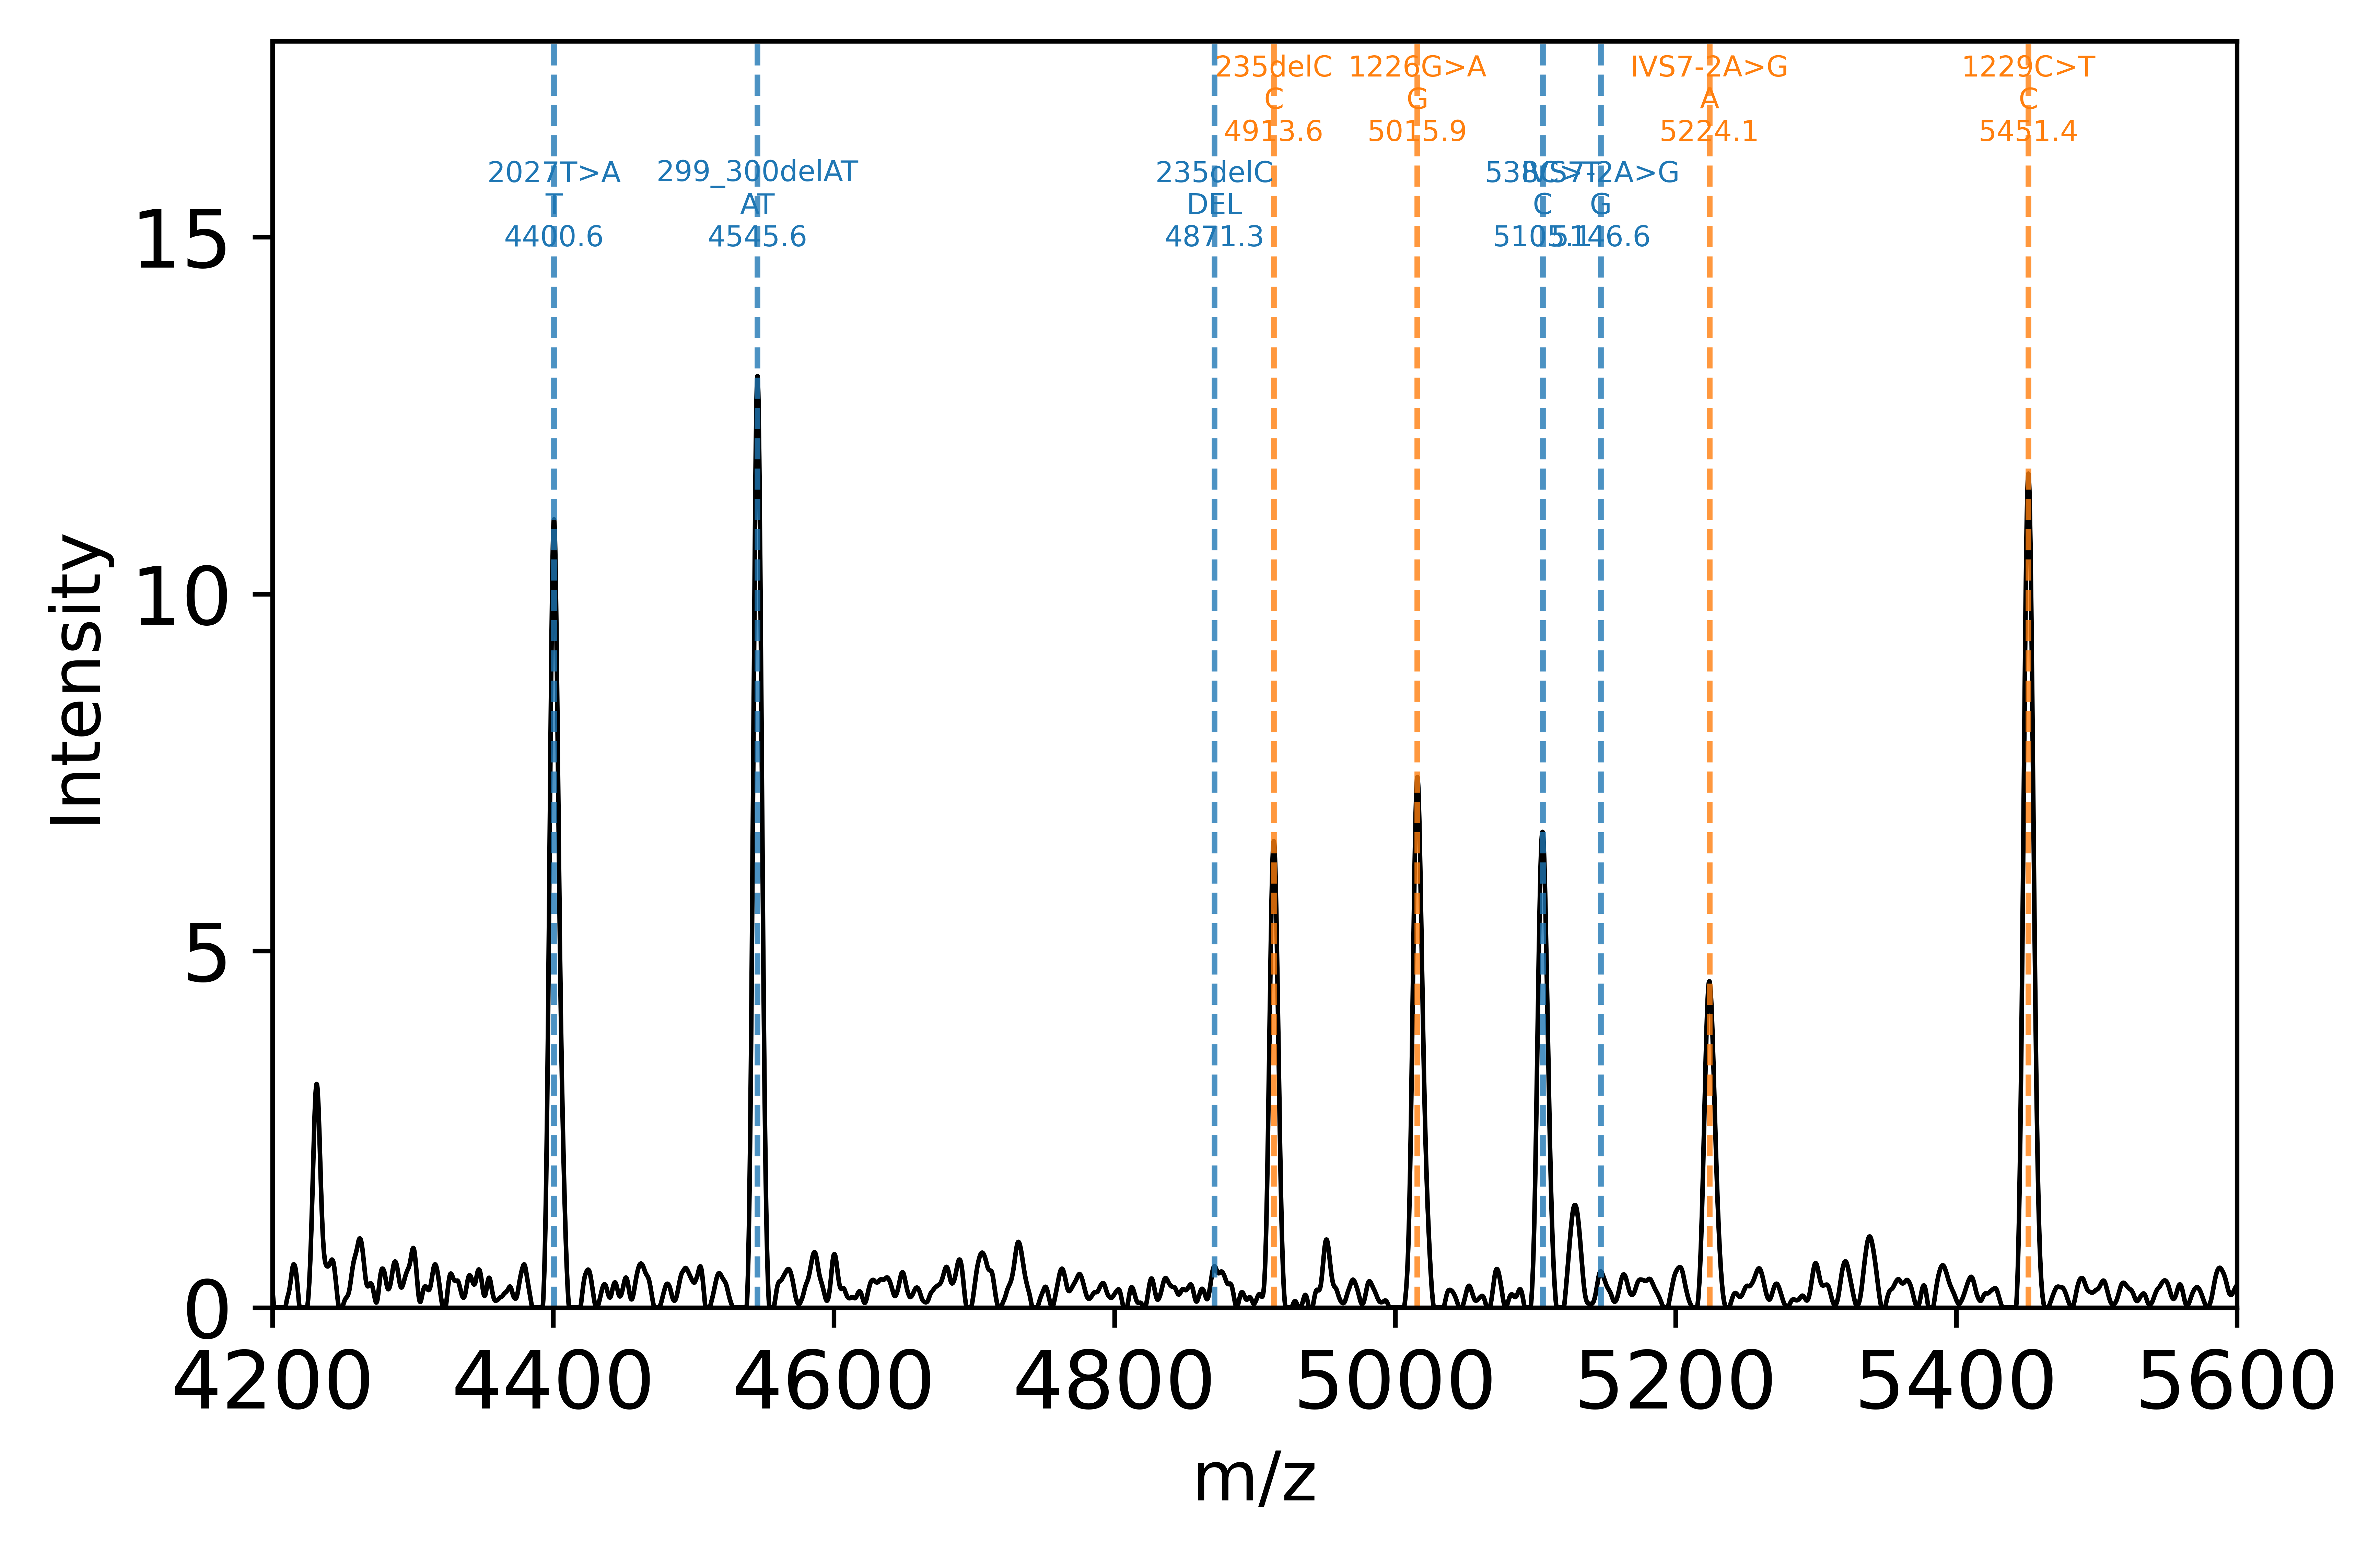

检测到的峰数量（S/N>3）：88
匹配到的位点数量：
在产物1（5 Da）/产物2（5 Da）容差下，匹配到 22/22 个目标位点
匹配详情：
- 281C>T: 产物2（理论4191.8 → 实测4192.2）
- 2027T>A: 产物1（理论4399.9 → 实测4400.6）
- 299_300delAT: 产物1（理论4545.0 → 实测4545.6）
- 235delC: 产物1（理论4873.2 → 实测4871.3）产物2（理论4913.2 → 实测4913.6）
- 1226G>A: 产物2（理论5015.3 → 实测5015.9）
- 538C>T: 产物1（理论5104.4 → 实测5105.1）
- IVS7-2A>G: 产物1（理论5143.4 → 实测5146.6）产物2（理论5223.3 → 实测5224.1）
- 1229C>T: 产物2（理论5450.6 → 实测5451.4）
- 109G>A: 产物1（理论5626.7 → 实测5627.3）
- 35delG: 产物1（理论5648.7 → 实测5649.6）
- 176_191del16: 产物1（理论5874.9 → 实测5875.7）产物2（理论5930.8 → 实测5928.0）
- 1555A>G: 产物2（理论6080.9 → 实测6081.6）
- 2162C>T: 产物1（理论6049.0 → 实测6049.7）
- 1975G>C: 产物2（理论6636.4 → 实测6637.0）
- 1095T>C: 产物2（理论6996.5 → 实测6996.9）
- 2168A>G: 产物2（理论7109.5 → 实测7110.0）
- 1494C>T: 产物1（理论7829.2 → 实测7829.2）
- 1174A>T: 产物2（理论7496.8 → 实测7497.3）
- 547G>A: 产物1（理论7660.0 → 实测7660.3）
- IVS15+5G>A: 产物1（理论8290.5 → 实测8290.0）
- 589G>A: 产物1（理论8461.5 → 实测8460.7）
- ACTB: 产物2（理论6460.2 → 实测6460.8）


In [6]:
# 子图3：高斯平滑后谱图 + 峰标注 + 位点标注（聚焦4200–4800 m/z）
plt.figure(figsize=(6, 4), dpi=1200)

# 绘制高斯平滑后的谱图
plt.plot(m_crop, i_smoothed, color='black', lw=0.8, label=f'Gaussian Smoothed (σ={sigma})')



# 位点标注（仅标注4200–4800范围内的匹配位点）
tolerance = 5  # 统一容差
for site, prod1, mz1, prod2, mz2 in sites:
    # 筛选该区间内的理论位点
    if 4200 <= mz1 <= 5600:
        if np.any(np.abs(peaks_mz - mz1) < tolerance):
            idx = np.argmin(np.abs(peaks_mz - mz1))
            mz_exp = peaks_mz[idx]
            plt.axvline(mz_exp, color=color1, ls='--', lw=1, alpha=0.8)
            plt.text(mz_exp, i_smoothed.max() * 1.0,
                     f'{site}\n{prod1}\n{mz_exp:.1f}',
                     ha='center', va='bottom', fontsize=5, color=color1, rotation=0)
    
    if 4200 <= mz2 <= 5600:
        if np.any(np.abs(peaks_mz - mz2) < tolerance):
            idx = np.argmin(np.abs(peaks_mz - mz2))
            mz_exp = peaks_mz[idx]
            plt.axvline(mz_exp, color=color2, ls='--', lw=1, alpha=0.8)
            plt.text(mz_exp, i_smoothed.max() * 1.1,
                     f'{site}\n{prod2}\n{mz_exp:.1f}',
                     ha='center', va='bottom', fontsize=5, color=color2, rotation=0)
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})
# 图表基础设置（重点修改xlim为4200–4800）
plt.xlabel('m/z', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.xlim(4200, 5600)  # 修改x轴范围
plt.ylim(0, i_smoothed.max() * 1.2)  # 保持y轴范围，避免标注被截断
plt.tight_layout()
plt.show()

# --- 输出结果统计（不受x轴范围影响，仍基于所有检测到的峰）---
print(f"检测到的峰数量（S/N>3）：{len(peaks_mz)}")
print(f"匹配到的位点数量：")

tolerance_prod1 = 5
tolerance_prod2 = 5
matched_sites = 0
matched_details = []

for site, prod1, mz1, prod2, mz2 in sites:
    prod1_matched = any(np.abs(peaks_mz - mz1) < tolerance_prod1)
    prod2_matched = any(np.abs(peaks_mz - mz2) < tolerance_prod2)
    
    if prod1_matched or prod2_matched:
        matched_sites += 1
        match_info = f"- {site}: "
        if prod1_matched:
            closest_mz = peaks_mz[np.argmin(np.abs(peaks_mz - mz1))]
            match_info += f"产物1（理论{mz1:.1f} → 实测{closest_mz:.1f}）"
        if prod2_matched:
            closest_mz = peaks_mz[np.argmin(np.abs(peaks_mz - mz2))]
            match_info += f"产物2（理论{mz2:.1f} → 实测{closest_mz:.1f}）"
        matched_details.append(match_info)

print(f"在产物1（{tolerance_prod1} Da）/产物2（{tolerance_prod2} Da）容差下，匹配到 {matched_sites}/{len(sites)} 个目标位点")
if matched_details:
    print("匹配详情：")
    for detail in matched_details:
        print(detail)